In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
vl.__version__

AttributeError: module 'volprice' has no attribute '__version__'

In [5]:
kharpov = True

In [6]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.01,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -4.45,
                   'log_scale': -3.48,
                   'logit_rho': 1.21,
                   'phi': -0.01,
                    'pi': -22.7, 
                   'theta': 0.28}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10_000
sim_dim = 250
innov_dim = 250

In [7]:
bounds = {'pi': {'max': 0, 'min':-25, 'dim':32}, 'phi': {'max': 0, 'min':-.5, 'dim':4}, 
          'theta': {'max':2.5, 'min': 0, 'dim':12}}

In [8]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [9]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [10]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                   pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.016279885604144832,
 'return_var': 0.013096576986779667,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [11]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [12]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.012413,0.016062
std,0.015545,0.112118
min,0.000010,-0.536776
25%,0.002009,-0.033785
50%,0.006846,0.005394
75%,0.016933,0.058683
max,0.164931,0.850766


In [13]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

In [14]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [15]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

## We start by examining the distributions of simulated data

In [16]:
data.corr()

,vol,rtn
vol,1.000000,0.197401
rtn,0.197401,1.000000


In [17]:
data.head()

,vol,rtn
2000-01-01,0.010752,0.001140
2000-01-02,0.002568,-0.022586
2000-01-03,0.006736,-0.128048
2000-01-04,0.004857,0.121624
2000-01-05,0.008723,0.070986


In [18]:
data.var()

vol    0.000242
rtn    0.012570
dtype: float64

In [19]:
vl.compute_vol_gmm(data.vol)

({'log_both': -5.951795573802607,
  'log_scale': -5.49631793850452,
  'logit_rho': 1.3246856284543291},
            log_both  log_scale  logit_rho
 log_both   0.001289   0.000233  -0.001435
 log_scale  0.000233   0.000410  -0.000086
 logit_rho -0.001435  -0.000086   0.003691)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
total_est, total_cov = vl.estimate_params_strong_id(data, bounds=bounds)

In [22]:
omega

{'gamma': 0.00014556079603848527,
 'beta': 0.07710125226168903,
 'psi': 1.205301909150779,
 'zeta': 0.9813269502459939,
 'log_both': -5.951795573802607,
 'log_scale': -5.49631793850452,
 'logit_rho': 1.3246856284543291}

In [23]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.003530,-8.403835e-06,0.000000,0.000000,0.000000,-0.002853,0.000000
gamma,-0.000008,6.518709e-08,0.000000,0.000000,0.000000,0.000003,0.000000
log_both,0.000000,0.000000e+00,0.001289,0.000233,-0.001435,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000233,0.000410,-0.000086,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.001435,-0.000086,0.003691,0.000000,0.000000
psi,-0.002853,3.152415e-06,0.000000,0.000000,0.000000,0.010508,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000188


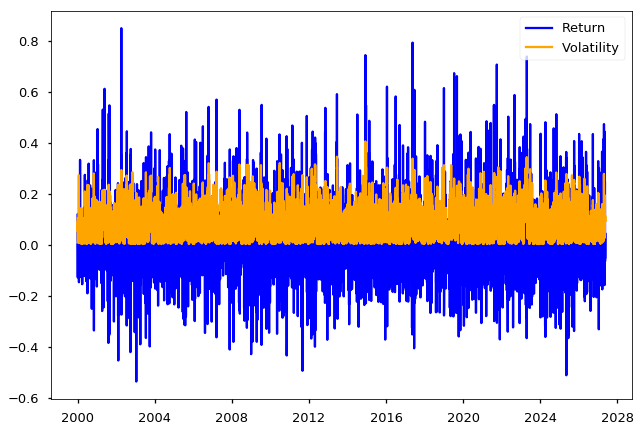

In [24]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [25]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003798,0.001248
rtn,0.001248,0.012570


In [26]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': 1.155240016994922,
 'beta': 0.09722424544370156,
 'gamma': 0.000298574376639809,
 'zeta': 0.9999}

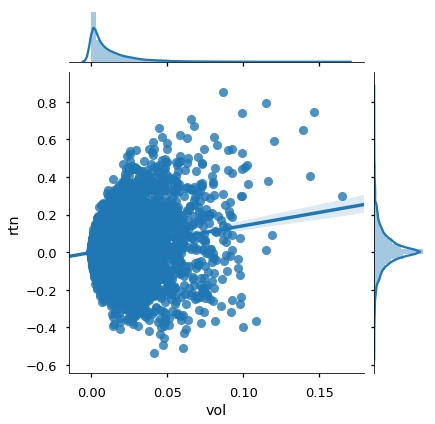

In [27]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [28]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.012413,0.016062
std,0.015545,0.112118
min,0.000010,-0.536776
25%,0.002009,-0.033785
50%,0.006846,0.005394
75%,0.016933,0.058683
max,0.164931,0.850766


## I now estimate all of the parameters

In [29]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [30]:
vl.compute_init_constants(data.vol)

{'log_both': -5.953432406815158,
 'log_scale': -5.5034531561271525,
 'logit_rho': 1.3296164589068487}

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -5.962895180785596,
  'log_scale': -5.517782218113201,
  'logit_rho': 1.3903134711091556},
            log_both  log_scale  logit_rho
 log_both   0.001408   0.000219  -0.001524
 log_scale  0.000219   0.000474  -0.000034
 logit_rho -0.001524  -0.000034   0.003802)

In [33]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [34]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [35]:
estimator(data_arr[0])

({'gamma': 0.0004395450101603501,
  'beta': 0.06319394049026081,
  'psi': 1.0611059097487856,
  'zeta': 0.990845655196645,
  'log_both': -5.962895180785596,
  'log_scale': -5.517782218113201,
  'logit_rho': 1.3903134711091556,
  'phi': -0.010490662231368126,
  'pi': 0.0,
  'theta': 1.6588633593011817},
                beta         gamma  log_both  log_scale  logit_rho  \
 beta       0.003627 -9.262576e-06  0.000000   0.000000   0.000000   
 gamma     -0.000009  6.687137e-08  0.000000   0.000000   0.000000   
 log_both   0.000000  0.000000e+00  0.001408   0.000219  -0.001524   
 log_scale  0.000000  0.000000e+00  0.000219   0.000474  -0.000034   
 logit_rho  0.000000  0.000000e+00 -0.001524  -0.000034   0.003802   
 phi             NaN           NaN       NaN        NaN        NaN   
 pi              NaN           NaN       NaN        NaN        NaN   
 psi       -0.002909  4.084823e-06  0.000000   0.000000   0.000000   
 theta           NaN           NaN       NaN        NaN        NaN

In [36]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [37]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [38]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

In [39]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta','psi']


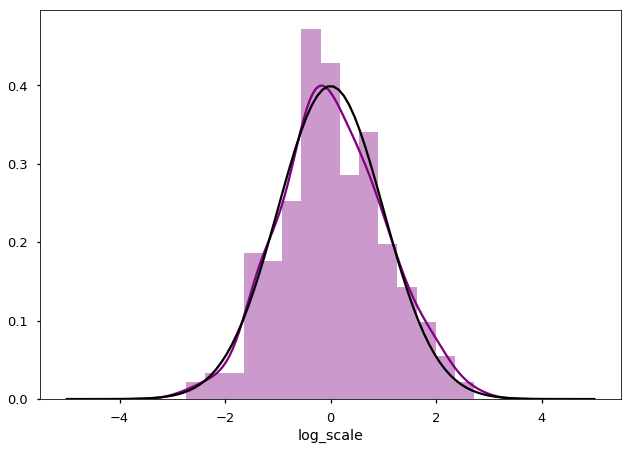

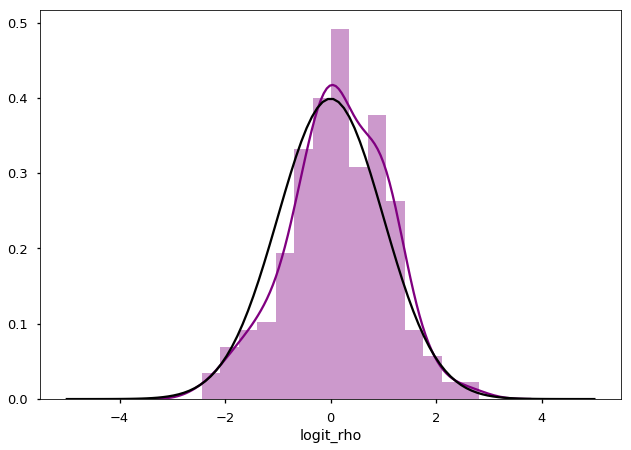

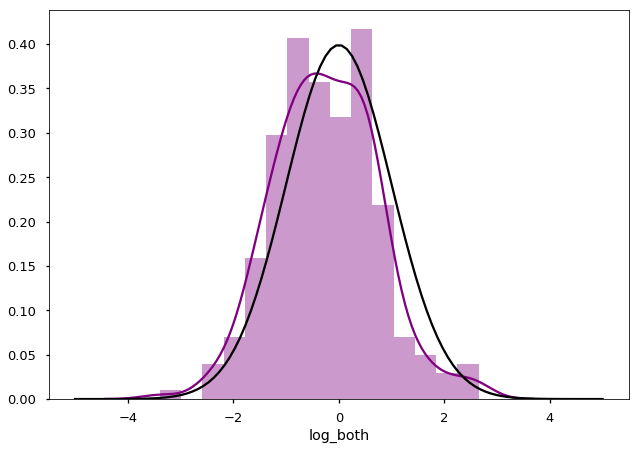

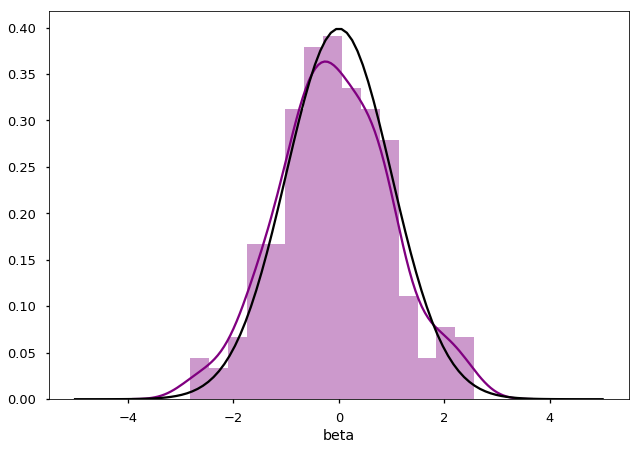

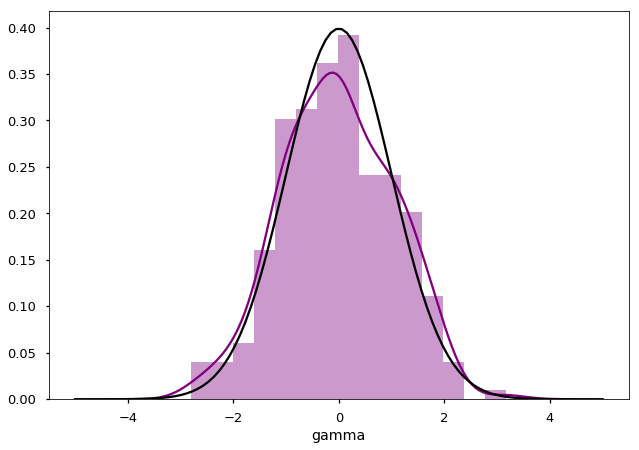

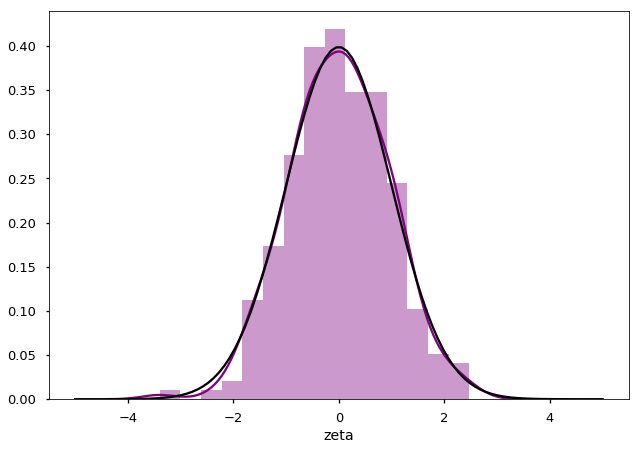

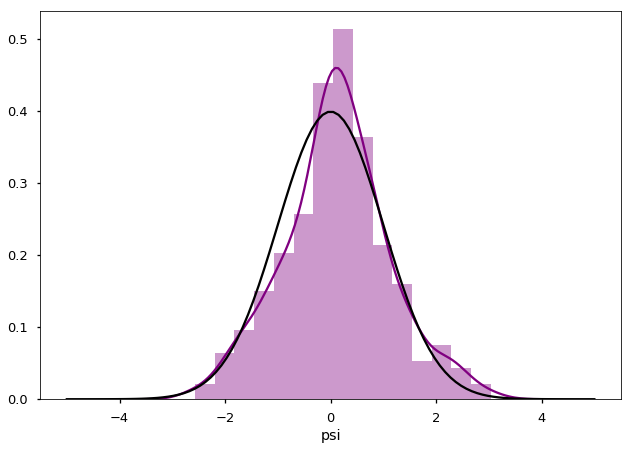

In [40]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in rf_names:
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=15, color='purple')
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [41]:
def link_function_t_stats(est):
    params = est[0]
    st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [42]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

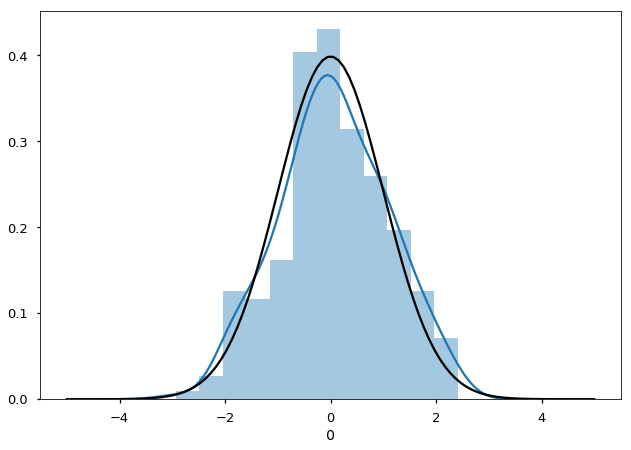

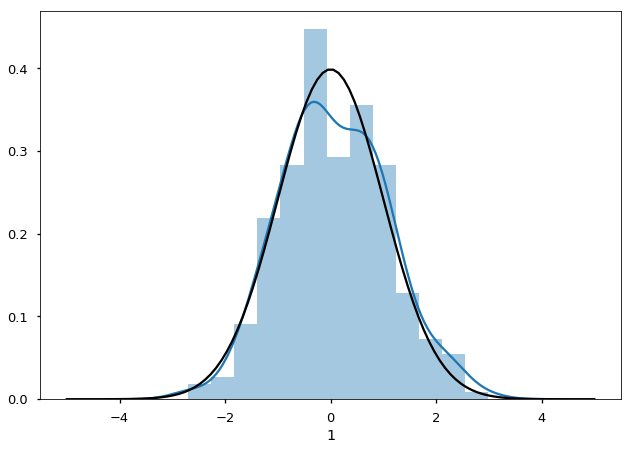

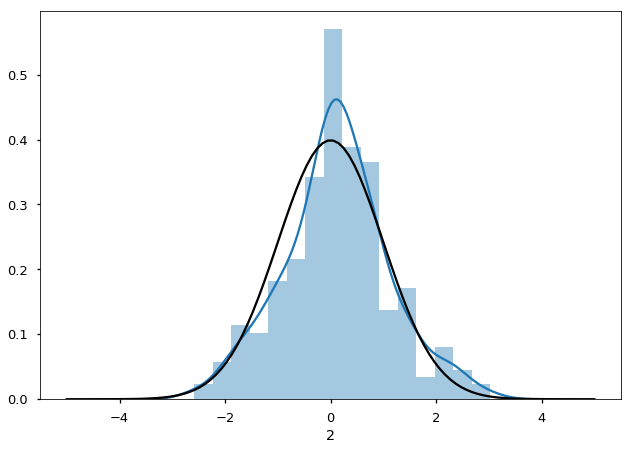

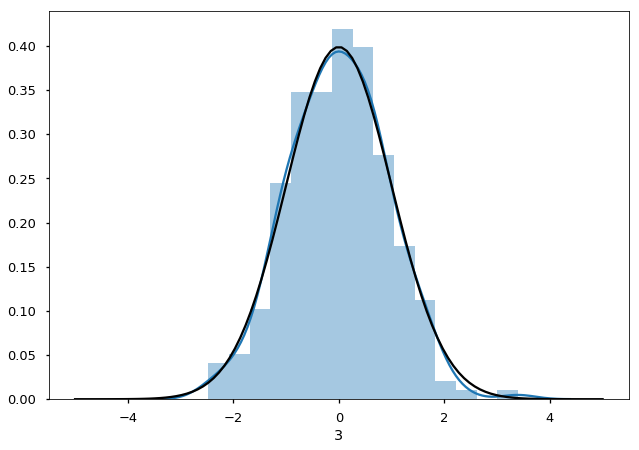

In [43]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [ ]:
bounds

In [ ]:
for name in ['phi', 'pi', 'theta']:
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(pd.Series([est[name] 
                                for est, cov in est_arr]).dropna(), ax=ax, color='purple', bins=25,
                     kde=False, norm_hist=True)
    diff = (bounds[name]['max'] - bounds[name]['min'])
    ax.set_xlim([bounds[name]['min'] - .05 * diff ,  bounds[name]['max'] + .05 * diff])

    ax.set_ylim([0, 10 / diff])
    ax.axvline(true_params[name], color='black')
        
    ax.set_xlabel(f"$\{name}$")

    fig.savefig(f"../doc/figures/{name}_est_{innov_dim}_" + "{:.2f}".format(true_params['phi']).replace(
        ".", "_point_").replace("-", "minus_") + ".tmp.pdf", frameon=False, pad_inches=0,
                bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [44]:
omega

{'gamma': 0.00014556079603848527,
 'beta': 0.07710125226168903,
 'psi': 1.205301909150779,
 'zeta': 0.9813269502459939,
 'log_both': -5.951795573802607,
 'log_scale': -5.49631793850452,
 'logit_rho': 1.3246856284543291}

In [45]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.01,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [46]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [47]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [48]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

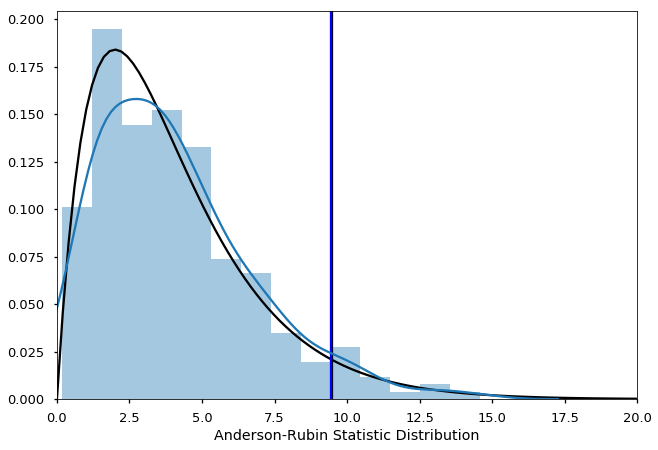

In [49]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')

    sns.distplot(ar_results, ax=ax)
    

In [50]:
np.mean(ar_results >= stats.chi2.ppf(df=4, q=.95))

0    0.048
dtype: float64

In [51]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [52]:
true_prices

[-0.01, -10, 1.768]

In [53]:
umm = []
for est in tqdm.tqdm_notebook(est_arr):
    omega_in = pd.Series(est[0]).loc[rf_names].to_dict()
    omega_cov_in = est[1].loc[rf_names, rf_names]
    minimize_result = vl._minimize_multiple_x0(vl._qlr_in, init1=true_prices,
                                            init2=true_prices, omega=omega_in,
                                            omega_cov=omega_cov_in, bounds=bounds)
    qlr_stat = vl.qlr_stat(true_prices, bounds=bounds, omega_cov=omega_cov_in, omega=omega_in)[-1]
    qlr_draw = vl._minimize_multiple_x0(vl._qlr_in_star,init1=true_prices,
                                                            init2=true_prices,
                                                            omega=omega_in,
                                                            omega_cov=omega_cov_in,
                                                            bounds=bounds,
                                                            true_prices=true_prices,
                                                            innov=np.random.standard_normal(4)).fun
    ar_stat = vl._qlr_in(prices=true_prices, omega=omega_in, omega_cov=omega_cov_in)

    umm.append([ar_stat, qlr_stat, minimize_result.fun, qlr_draw])

In [58]:
pd.DataFrame(umm)

,0,1,2,3
0,8.259542,6.860082,1.447956,0.638799
1,5.260134,4.818275,0.442319,0.974646
2,2.590795,1.836339,0.754456,0.162823
3,6.355593,0.226222,6.183272,4.835232
4,3.965904,3.759773,0.206131,0.164723
5,8.280758,2.793676,5.487082,3.118114
6,3.743957,2.644072,1.099901,4.008123
7,6.116869,4.833141,1.284169,1.778540
8,3.314517,0.482912,2.868386,0.524307
9,11.752762,10.280427,1.472335,1.197200


In [54]:
est = est_arr[0]
omega_in = pd.Series(est[0]).loc[rf_names].to_dict()
omega_cov_in = est[1].loc[rf_names, rf_names]
minimize_result = vl._minimize_multiple_x0(vl._qlr_in, init1=true_prices,
                                            init2=true_prices, omega=omega_in,
                                            omega_cov=omega_cov_in, bounds=bounds)

In [55]:
 qlr_draw =[ vl._minimize_multiple_x0(vl._qlr_in_star,init1=true_prices,
                                                            init2=true_prices,
                                                            omega=omega_in,
                                                            omega_cov=omega_cov_in,
                                                            bounds=bounds,
                                                            true_prices=true_prices,
                                                            innov=np.random.standard_normal(4)) for _ in tqdm.tnrange(100)]

In [62]:
other_draws = [vl._qlr_in_star(true_prices, np.random.standard_normal(4), omega_in, omega_cov_in, true_prices) 
               for _ in range(5000)]

In [66]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=100, alpha=None, robust_quantile=True, bounds=bounds)
total=min(100, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
                                                                                    est_arr[:total]),
                                                          total=total))))

In [67]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [68]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [69]:
ar_pit = stats.chi2.cdf(ar_results, df=4)

In [70]:
np.sort(np.ravel(results[0]))

array([9.417e-03, 6.305e-02, 6.939e-02, 7.338e-02, 8.538e-02, 1.000e-01,
       1.196e-01, 1.615e-01, 1.662e-01, 2.009e-01, 2.300e-01, 2.740e-01,
       3.059e-01, 3.091e-01, 3.118e-01, 3.162e-01, 3.509e-01, 3.588e-01,
       3.828e-01, 3.994e-01, 4.305e-01, 4.413e-01, 4.829e-01, 4.947e-01,
       5.034e-01, 5.424e-01, 5.511e-01, 5.779e-01, 6.406e-01, 6.566e-01,
       7.671e-01, 7.680e-01, 8.252e-01, 8.517e-01, 9.074e-01, 9.709e-01,
       9.825e-01, 1.031e+00, 1.119e+00, 1.121e+00, 1.172e+00, 1.213e+00,
       1.288e+00, 1.325e+00, 1.340e+00, 1.340e+00, 1.562e+00, 1.573e+00,
       1.644e+00, 1.684e+00, 1.724e+00, 1.740e+00, 1.819e+00, 1.836e+00,
       1.841e+00, 1.846e+00, 1.907e+00, 1.924e+00, 1.947e+00, 1.979e+00,
       2.019e+00, 2.138e+00, 2.174e+00, 2.274e+00, 2.313e+00, 2.322e+00,
       2.374e+00, 2.454e+00, 2.488e+00, 2.534e+00, 2.557e+00, 2.638e+00,
       2.644e+00, 2.652e+00, 2.794e+00, 2.918e+00, 3.042e+00, 3.053e+00,
       3.087e+00, 3.385e+00, 3.667e+00, 3.690e+00, 

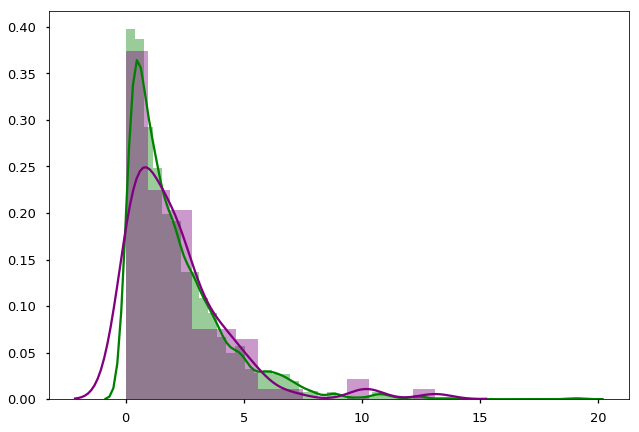

In [73]:
fig, ax = mpl.pyplot.subplots()
sns.distplot(np.ravel(results.iloc[:,1:]), ax=ax, color='green')
# sns.distplot(np.ravel(ar_results), ax=ax, color='red')
sns.distplot(np.ravel(results.iloc[:,0]), ax=ax, color='purple')

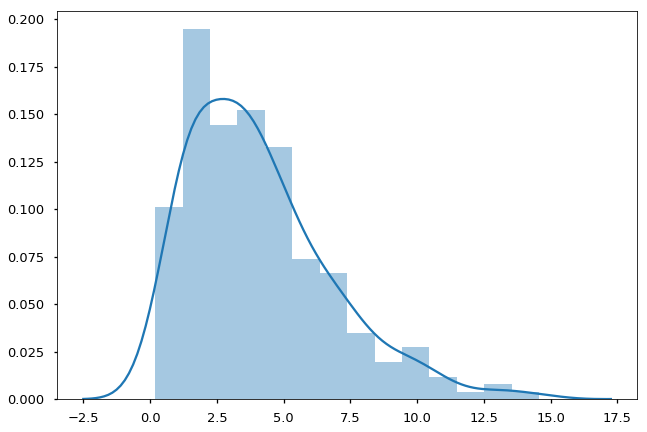

In [74]:
sns.distplot(ar_results)

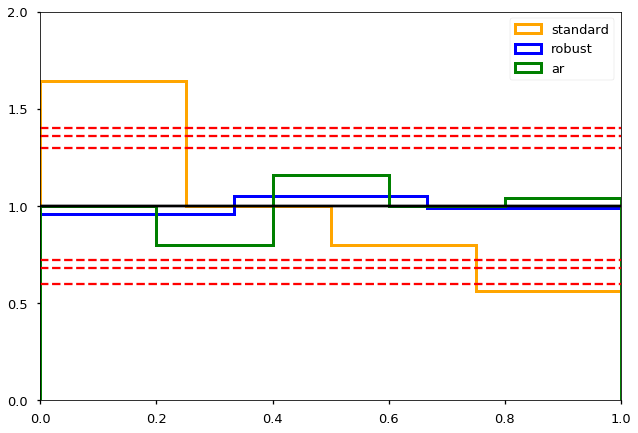

In [75]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
cdpm.pit_plot(ar_pit, ax=ax, color='green', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='ar')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [77]:
qlr_stat

0.9956749957770255

In [78]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [79]:
np.percentile(returnval.qlr_stat, 95)

5.705600024061633

In [80]:
true_params['phi']

-0.01

In [87]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

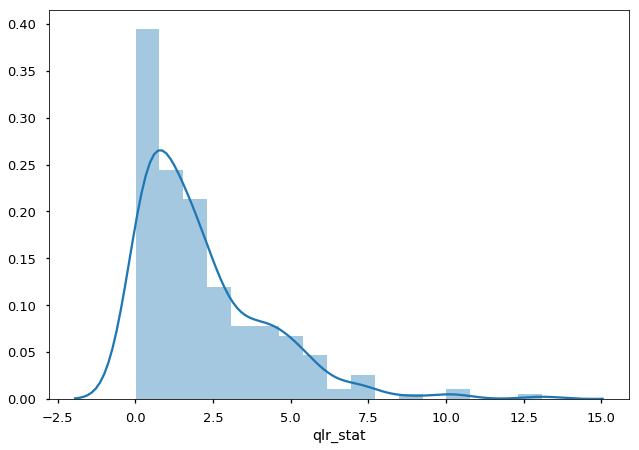

In [82]:
sns.distplot(returnval.qlr_stat)

In [83]:
returnval.query('robust_qlr_qauntile < 9.48').mean()

qlr_stat               2.155342
robust_qlr_qauntile    5.787305
robust                 0.044000
standard               0.016000
dtype: float64

In [84]:
returnval.mean()

qlr_stat               2.155342
robust_qlr_qauntile    5.787305
robust                 0.044000
standard               0.016000
dtype: float64

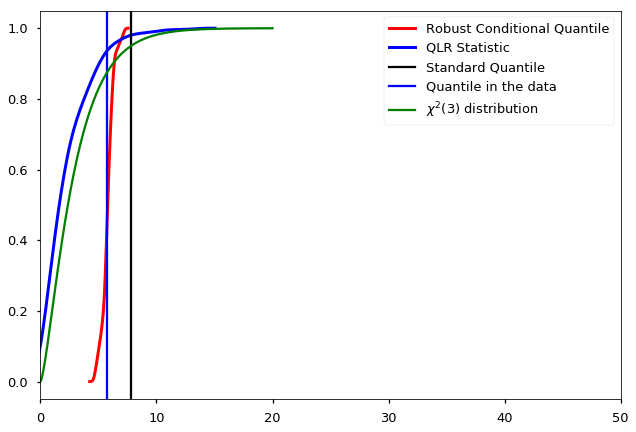

In [85]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)